## Computer Vision Coursework Project - HOG + SVM Model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Computer Vision/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset', 'Models', 'Personal_Video', 'test_function.ipynb']


The code in the following box was written with the help of the code present in lab 6 [1].

In [3]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2024_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

In [4]:
# Make a folder to put the train and test sets into it
!mkdir -p CV2024_CW_Dataset

# Move files to CV2024_CW_Dataset folder
!mv test CV2024_CW_Dataset/
!mv train CV2024_CW_Dataset/

Let's now import all the appropriate libraries to run the coding task.

In [5]:
from skimage import img_as_ubyte, io, color
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

The following is a function used to load images with their respective labels, taken from lab 6 [1] and modified for the relevant data.

In [6]:
def import_selected_data(image_folder, label_folder):
    """Load images and labels from selected directories"""
    # Creates empty lists for both images and labels
    images = []
    labels = []

    # Lists all files in the image folder and filters them to only keep .jpeg files
    image_files = [f for f in sorted(os.listdir(image_folder)) if f.endswith('.jpeg')]

    # Loops over every image file + builds full paths to both images and labels
    for img_file in image_files:
      img_path = os.path.join(image_folder, img_file)
      label_path = os.path.join(label_folder, img_file.replace('.jpeg','.txt'))

      # Loads the image + appends it to the images list
      img = io.imread(img_path)
      images.append(img)

      # Loads the label + converts it to an integer + appends it to the labels list
      with open (label_path, 'r') as f:
        label = int(f.readline().strip())
      labels.append(label)

    return images, labels

In [7]:
X_train, y_train = import_selected_data('CV2024_CW_Dataset/train/images', 'CV2024_CW_Dataset/train/labels')
X_test, y_test = import_selected_data('CV2024_CW_Dataset/test/images', 'CV2024_CW_Dataset/test/labels')

In [8]:
# Let's check the data distribution of labels
print(Counter(y_train))
print(Counter(y_test))

Counter({1: 1940, 0: 376, 2: 78})
Counter({1: 388, 0: 51, 2: 19})


Now, as it can be seen the labels between each class are quite imbalanced, let's try and fix this by using the imbalanced learn package, with the help of the code and explanation provided in [2].

In [9]:
# Let's first install the imbalanced-learn library
!pip install -U imbalanced-learn

In [10]:
import imblearn
print(imblearn.__version__)

0.13.0


In [11]:
print(X_train[0].shape)
print(X_train[5].shape)
print(X_train[10].shape)

(37, 30, 3)
(23, 16, 3)
(29, 29, 3)


As shown by the above cell, the images in the training folder have different sizes, so before balancing the dataset, let's resize AND flatten all images (after resampling we will convert them back to a common image shape - e.g. (64,64,3)).

In [12]:
# Import function to resize images
from skimage.transform import resize

# Set a standard image size
target_size = (64, 64)

# Overwrite with resized images
X_train = [resize(img, target_size + (3,), anti_aliasing=True) for img in X_train]

# Flatten each image and put them in array format
X_train = [img.flatten() for img in X_train]
X_train = np.array(X_train)

Resample images by oversampling classes 0 and 2 and undersampling class 1 - code taken from [2].

In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print("Original Sample:",Counter(y_train))

# Oversampling the two minority classes
over = RandomOverSampler(sampling_strategy = {0:1000, 2:1000})
X_train, y_train = over.fit_resample(X_train,y_train)
print("After Over Sampling:", Counter(y_train))

# Undersampling the majority class
under = RandomUnderSampler(sampling_strategy = {0:1000, 1:1000})
X_train, y_train = under.fit_resample(X_train, y_train)
print("After Under Sampling:", Counter(y_train))

Original Sample: Counter({1: 1940, 0: 376, 2: 78})
After Over Sampling: Counter({1: 1940, 0: 1000, 2: 1000})
After Under Sampling: Counter({0: 1000, 1: 1000, 2: 1000})


In [14]:
# Converting all images back to a common shape and size
X_train = X_train.reshape(-1, 64, 64, 3)

Since we now have all images in the training set of the same size and shape, let's make it fair and apply it also to the test set.

In [15]:
# Set a standard image size
target_size = (64, 64)

# Overwrite with resized images
X_test = [resize(img, target_size + (3,), anti_aliasing=True) for img in X_test]

print("Image train size:",X_train[0].shape)
print("Image test size:",X_test[0].shape)

Image train size: (64, 64, 3)
Image test size: (64, 64, 3)


## HOG + SVM

Now that our dataset is balanced, we can go ahead and run a grid search to find the optimal HOG parameters, which will then be used with our classifier.

Parts of the below code were taken from lab 5 [3].

In [16]:
# Import relevant libraries and functions
from skimage.feature import hog
from skimage import data, exposure
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Grid of parameters to loop
orientation_values = [8, 9, 10]
pixel_values = [(6,6), (8,8)]
cell_values = [(1,1), (2,2)]

best_score = 0
best_config = {}

# Looping over orientations, pixels and cells
for orientations in orientation_values:
  for pixels_per_cell in pixel_values:
    for cells_per_block in cell_values:
      hog_features = []

      # Extracting features
      for img in X_train:
        # Converting images in training set to gray_scale
        gray = img_as_ubyte(color.rgb2gray(img))
        HOG_des = hog(gray,
                      orientations=orientations,
                      pixels_per_cell=pixels_per_cell,
                      cells_per_block=cells_per_block,
                      visualize=False,
                      feature_vector=True)
        hog_features.append(HOG_des)

      # Putting hog_features in array format
      hog_features = np.array(hog_features)

      # Training standard SVM classifier
      classifier = svm.SVC(kernel='rbf')
      # Implementing a StratifiedKFold for reproducibility
      cv = StratifiedKFold(n_splits=5, shuffle=True, random_state= 42)
      scores = cross_val_score(classifier, hog_features, y_train, cv=cv)
      mean_score = scores.mean()

      print(f"orientations={orientations}, pixels_per_cell={pixels_per_cell},cells_per_block={cells_per_block} → Accuracy: {mean_score:.4f}")

      # Tracking the best combination of hyper-parameters
      if mean_score > best_score:
                best_score = mean_score
                best_params = {
                    'orientations': orientations,
                    'pixels_per_cell': pixels_per_cell,
                    'cells_per_block': cells_per_block
                    }

print("Best HOG configuration:", best_params)
print("Best accuracy:", best_score)

orientations=8, pixels_per_cell=(6, 6),cells_per_block=(1, 1) → Accuracy: 0.9497
orientations=8, pixels_per_cell=(6, 6),cells_per_block=(2, 2) → Accuracy: 0.9647
orientations=8, pixels_per_cell=(8, 8),cells_per_block=(1, 1) → Accuracy: 0.9473
orientations=8, pixels_per_cell=(8, 8),cells_per_block=(2, 2) → Accuracy: 0.9640
orientations=9, pixels_per_cell=(6, 6),cells_per_block=(1, 1) → Accuracy: 0.9513
orientations=9, pixels_per_cell=(6, 6),cells_per_block=(2, 2) → Accuracy: 0.9650
orientations=9, pixels_per_cell=(8, 8),cells_per_block=(1, 1) → Accuracy: 0.9490
orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2) → Accuracy: 0.9660
orientations=10, pixels_per_cell=(6, 6),cells_per_block=(1, 1) → Accuracy: 0.9537
orientations=10, pixels_per_cell=(6, 6),cells_per_block=(2, 2) → Accuracy: 0.9680
orientations=10, pixels_per_cell=(8, 8),cells_per_block=(1, 1) → Accuracy: 0.9507
orientations=10, pixels_per_cell=(8, 8),cells_per_block=(2, 2) → Accuracy: 0.9627
Best HOG configuration: 

Now that we have the optimal hyper-parameter values, we can extract HOG features with these and then perform a grid search for the SVC kernel parameters.

In [17]:
hog_features = []

# Extracting features
for img in X_train:
  # Converting images in training set to gray_scale
  gray = img_as_ubyte(color.rgb2gray(img))
  HOG_des = hog(gray,
                orientations=10,
                pixels_per_cell=(8,8),
                cells_per_block=(2,2),
                visualize=False,
                feature_vector=True)
  hog_features.append(HOG_des)

# Putting hog_features in array format
hog_features = np.array(hog_features)

In [18]:
# import GridSearchCV fucntion
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf']
}

grid = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

grid.fit(hog_features, y_train)

# Show best configuration
print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

# Final classifier
BEST_HOG_SVM = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.9696666666666667


Now that we've found the optimal hyper-parameter values and are done with training part, let's test our model's performance.

In [19]:
# Extract HOG descriptors from test images
hog_list = []

for i in range(len(X_test)):
    img = img_as_ubyte(color.rgb2gray(X_test[i]))
    HOG_des = hog(img,
                  orientations=10,
                  pixels_per_cell=(8,8),
                  cells_per_block=(2,2),
                  visualize=False,
                  feature_vector=True)
    hog_list.append(HOG_des)

X_test_hog = np.vstack(hog_list)

# Predict on best classifier
y_pred = BEST_HOG_SVM.predict(X_test_hog)

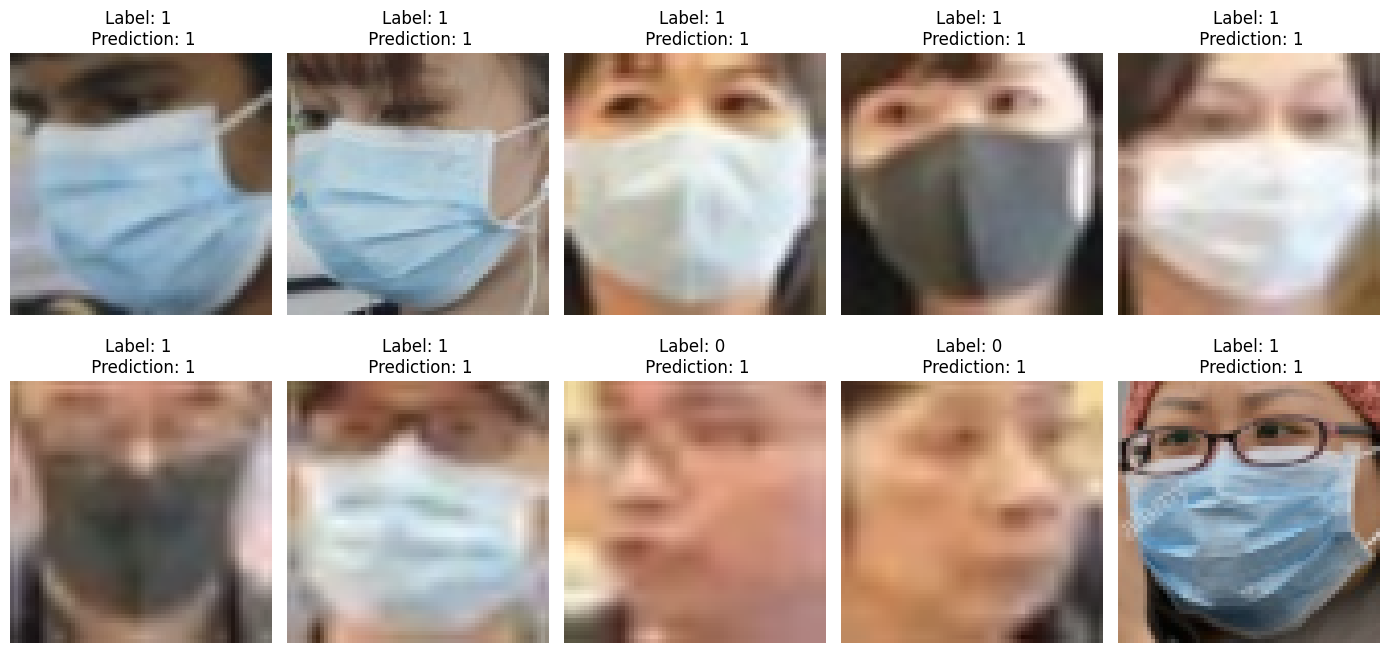

In [20]:
# Comparing predicted vs true labels
fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
ax = axes.ravel()

for i in range(10):
    ax[i].imshow(X_test[i])
    ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [21]:
# Evaluate results using classification report
from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.47      0.57        51
           1       0.90      0.98      0.94       388
           2       1.00      0.05      0.10        19

    accuracy                           0.88       458
   macro avg       0.87      0.50      0.54       458
weighted avg       0.88      0.88      0.86       458



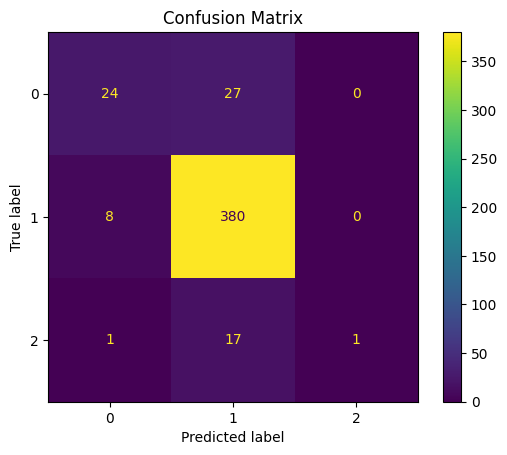

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.title("Confusion Matrix")
plt.show()

In [23]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.8843
Precision: 0.8817
Recall:    0.8843
F1 Score:  0.8607


## References

[1] G. Tarroni, *Lab_06_Solved,* unpublished lab tutorial, Dept. of Science and Technology, City St. George's, University of London, 2025.

[2] J. Brownlee, "Random Oversampling and Undersampling for Imbalanced Classification," Machine Learning Mastery. [Online]. Available at: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/. [Accessed: Apr. 21, 2025].

[3] G. Tarroni, *Lab_05_Solved,* unpublished lab tutorial, Dept. of Science and Technology, City St. George's, University of London, 2025.

Let's save the best model.

In [25]:
from joblib import dump

modelPath = "/content/drive/My Drive/Computer Vision/CW_Folder_PG/Models/BEST_HOG_SVM.joblib"
dump(BEST_HOG_SVM, modelPath)

['/content/drive/My Drive/Computer Vision/CW_Folder_PG/Models/BEST_HOG_SVM.joblib']